# SE3

Jordan's SE3 is a regression problem with $n = 200$ samples, $p = 10$ features and a signal $f(X) = X_1 X_2$. The response $Y$ is constructed as 

$$Y = f(X) + \varepsilon U,$$

where $U \sim \mathsf{N}(0,1)$ is as independent noise and $\varepsilon = 0.1$ is the noise level. The covariates $X_i, i \in [p]$ are $X_i \sim \mathsf{N}(0,1)$.

**Generator for reproducibility**

In [1]:
import torch

In [2]:
torch.manual_seed(16371051889608979414)

**Visualization**

In [3]:
from pyselect.data import jordan_se3

In [4]:
X_se3, y_se3 = jordan_se3()

In [5]:
import matplotlib.pyplot as plt
plt.style.use("../../../figures/pyselect.mplstyle")

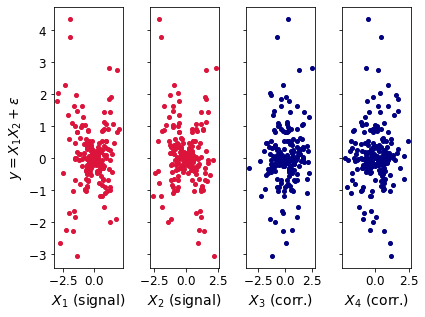

In [6]:
fig, ax = plt.subplots(ncols=4, sharey=True)
ax[0].plot(X_se3[:, 0], y_se3, 'o', markersize=4, color='crimson')
ax[0].set_xlabel(r"$X_1$ (signal)")
ax[0].set_ylabel(r"$y = X_1  X_2 + \epsilon$")
ax[1].plot(X_se3[:, 1], y_se3, 'o', markersize=4, color='crimson')
ax[1].set_xlabel("$X_2$ (signal)")
for i in range(2, 4):
    ax[i].plot(X_se3[:, i], y_se3, 'o', markersize=4, color='navy')
    ax[i].set_xlabel(f"$X_{i+1}$ (corr.)")
plt.subplots_adjust(wspace=0.4)
plt.show()

## Setup

In [7]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss
from ignite.handlers import LRScheduler, BasicTimeProfiler, EarlyStopping
from pyselect.networks import RandomFourierFeaturesNet

### Device

In [8]:
device = torch.device("cpu")

### Datasets

Generate data with fixed random seed.

In [9]:
X_se3, y_se3 = jordan_se3(n_samples=400)

Move to device

In [10]:
X_se3 = X_se3.to(device)
y_se3 = y_se3.to(device)

ata-splitting and generate datasets

In [11]:
train_size = 200
val_size = 100
test_size = 100

In [12]:
jordan_train_val_test = torch.utils.data.TensorDataset(X_se3, y_se3)

In [13]:
train, val, test = torch.utils.data.random_split(jordan_train_val_test, [train_size, val_size, test_size])

### Dataloaders

In [14]:
batch_size = 32

In [15]:
train_loader = DataLoader(train, batch_size=batch_size)
val_loader = DataLoader(val, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)

### Model

In [16]:
in_features = 10
out_features = 50

In [17]:
model = RandomFourierFeaturesNet(in_features, out_features)
model.to(device)

RandomFourierFeaturesNet(
  (rff_net): Sequential(
    (0): HadamardLayer(in_features=10)
    (1): RandomFourierFeaturesLayer(in_features=10, out_features=50)
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [18]:
model.rff_net[0].reset_parameters(1/in_features)

### Optimizer

In [19]:
lr = 1e-1
reg_param = 1e-7

In [20]:
optimizer = optim.SGD([{'params': model.rff_net[0].parameters()}, {'params':model.rff_net[2].weight, 'weight_decay': 2 * reg_param}, {'params': model.rff_net[2].bias}], lr=lr)

### Loss

In [21]:
from torch.nn import MSELoss

In [22]:
loss_fn = MSELoss()

### Trainer

In [23]:
n_epochs = 501

In [24]:
trainer = create_supervised_trainer(model, optimizer, loss_fn, device)

### Evaluators

In [25]:
val_metric = {"loss": Loss(loss_fn)}    
train_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)                                                
val_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)

### Scheduler

In [26]:
n_steps = 4
gamma = 0.97

In [27]:
step_size = len(train_loader)*n_epochs//n_steps
torch_scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
scheduler = LRScheduler(torch_scheduler)

In [28]:
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)

### Logger

In [29]:
log_every = 50

In [30]:
def log_training_results(engine):
    train_evaluator.run(train_loader)
    loss = train_evaluator.state.metrics['loss']
    print(f"Training - Epoch: {engine.state.epoch} Loss: {loss:.5f}")
    
def log_validation_results(engine):
    val_evaluator.run(val_loader)
    loss = val_evaluator.state.metrics['loss']
    print(f"Validation - Epoch: {engine.state.epoch} Loss: {loss:.5f}")    

def log_lr():
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.4f}")

In [31]:
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=log_every), log_training_results)
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=log_every), log_validation_results)
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=log_every), log_lr)

### Early Stopping

In [32]:
def score_function(engine):
    val_loss = engine.state.metrics['loss']
    return -val_loss

In [33]:
patience = 10

In [34]:
early_stopping = EarlyStopping(patience=patience, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, early_stopping)

### Time Profiler

In [35]:
time_profiler = BasicTimeProfiler()
time_profiler.attach(trainer)

## Train

In [36]:
trainer.run(train_loader, max_epochs=n_epochs)

Training - Epoch: 50 Loss: 0.12442
Validation - Epoch: 50 Loss: 0.35874
Learning rate: 0.1000
Training - Epoch: 100 Loss: 0.06058
Validation - Epoch: 100 Loss: 0.21026
Learning rate: 0.1000
Training - Epoch: 150 Loss: 0.04502
Validation - Epoch: 150 Loss: 0.16262
Learning rate: 0.0970
Training - Epoch: 200 Loss: 0.03782
Validation - Epoch: 200 Loss: 0.13774
Learning rate: 0.0970
Training - Epoch: 250 Loss: 0.03358
Validation - Epoch: 250 Loss: 0.12184
Learning rate: 0.0970
Training - Epoch: 300 Loss: 0.03081
Validation - Epoch: 300 Loss: 0.11092
Learning rate: 0.0941
Training - Epoch: 350 Loss: 0.02885
Validation - Epoch: 350 Loss: 0.10264
Learning rate: 0.0941
Training - Epoch: 400 Loss: 0.02735
Validation - Epoch: 400 Loss: 0.09623
Learning rate: 0.0913
Training - Epoch: 450 Loss: 0.02621
Validation - Epoch: 450 Loss: 0.09104
Learning rate: 0.0913
Training - Epoch: 500 Loss: 0.02530
Validation - Epoch: 500 Loss: 0.08669
Learning rate: 0.0913


State:
	iteration: 3507
	epoch: 501
	epoch_length: 7
	max_epochs: 501
	output: 0.009304138831794262
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

## Visualization

### Bands

In [37]:
import numpy as np

In [38]:
bands = model.rff_net[0].bandwidths.detach().to('cpu').numpy()
indexes = np.arange(1, in_features+1)

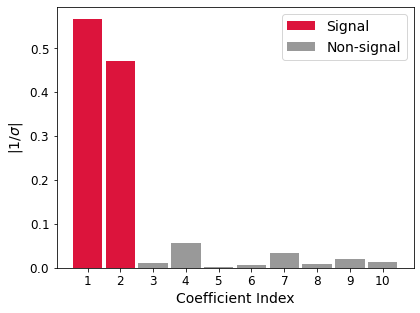

In [39]:
plt.bar(indexes[0:2], np.abs(bands)[0:2], width=0.9, color='crimson', label='Signal')
plt.bar(indexes[2:], np.abs(bands)[2:], width=0.9, color='black', alpha=0.4, label='Non-signal')
ax = plt.gca()
ax.ticklabel_format(axis="x", style="plain")
ax.set_xlabel("Coefficient Index")
ax.set_ylabel(r"$| 1/\sigma |$")
ax.set_xticks(indexes)
plt.legend()
plt.show()

### Predictions on test

In [40]:
model.to('cpu')

RandomFourierFeaturesNet(
  (rff_net): Sequential(
    (0): HadamardLayer(in_features=10)
    (1): RandomFourierFeaturesLayer(in_features=10, out_features=50)
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [41]:
X_test, y_test = test.dataset[test.indices]

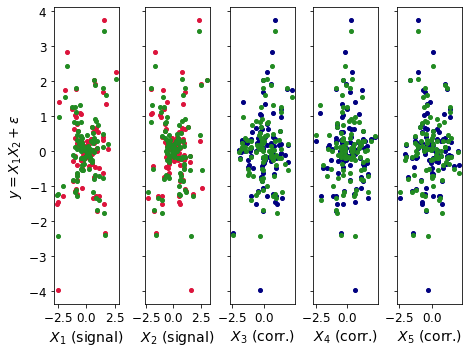

In [42]:
fig, ax = plt.subplots(ncols=5, sharey=True, constrained_layout=True)
ax[0].plot(X_test[:, 0], y_test, 'o', markersize=4, color='crimson')
ax[0].plot(X_test[:, 0], model(X_test).to('cpu').detach().numpy(), 'o', markersize=4, color='forestgreen')
ax[0].set_xlabel(r"$X_1$ (signal)")
ax[0].set_ylabel(r"$y = X_1  X_2 + \epsilon$")
ax[1].plot(X_test[:, 1], y_test, 'o', markersize=4, color='crimson')
ax[1].plot(X_test[:, 1], model(X_test).to('cpu').detach().numpy(), 'o', markersize=4, color='forestgreen')
ax[1].set_xlabel("$X_2$ (signal)")
for i in range(2, 5):
    ax[i].plot(X_test[:, i], y_test, 'o', markersize=4, color='navy')
    ax[i].plot(X_test[:, i], model(X_test).to('cpu').detach().numpy(), 'o', markersize=4, color='forestgreen')
    ax[i].set_xlabel(f"$X_{i+1}$ (corr.)")
plt.show()

In [43]:
sorted_y_test = y_test.squeeze().sort(dim=0)[0].numpy()

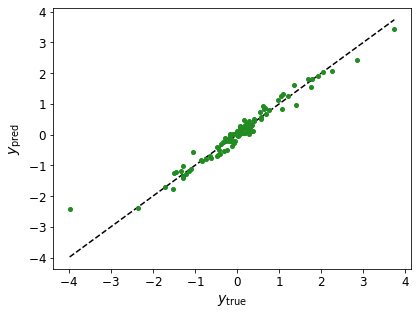

In [44]:
plt.plot(y_test, model(X_test).detach().squeeze().numpy(), 'o', markersize=4, color='forestgreen')
plt.plot(sorted_y_test, sorted_y_test, color='k', linestyle='dashed', zorder=-10)
plt.xlabel(r"$y_{\mathrm{true}}$")
plt.ylabel(r"$y_{\mathrm{pred}}$")
plt.show()

### Time profiling

In [45]:
results = time_profiler.get_results()

In [46]:
time_profiler.print_results(results);


 ----------------------------------------------------
| Time profiling stats (in seconds):                 |
 ----------------------------------------------------
total  |  min/index  |  max/index  |  mean  |  std

Processing function:
1.20558 | 0.00030/3310 | 0.02577/0 | 0.00034 | 0.00043

Dataflow:
0.73831 | 0.00010/3484 | 0.00072/2431 | 0.00021 | 0.00006

Event handlers:
0.11256

- Events.STARTED: []
0.00001

- Events.EPOCH_STARTED: []
0.00068 | 0.00000/105 | 0.00002/65 | 0.00000 | 0.00000

- Events.ITERATION_STARTED: ['LRScheduler']
0.03926 | 0.00001/3310 | 0.00004/3253 | 0.00001 | 0.00000

- Events.ITERATION_COMPLETED: []
0.00798 | 0.00000/3400 | 0.00003/2407 | 0.00000 | 0.00000

- Events.EPOCH_COMPLETED: ['log_training_results', 'log_validation_results', 'log_lr']
0.05301 | 0.00001/475 | 0.00514/249 | 0.00011 | 0.00066

- Events.COMPLETED: []
0.00000

